In [3]:
import pandas as pd
import sys
import Levenshtein
from  textprepare import TextColumnPrepare
from Levenshtein import *
# Total length 28588505

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
from tqdm import tqdm

In [12]:
TOTAL_LEN = 28588505
def readedits(fileerror, filecorrect, id_from=0, id_to=0, col_prep=TextColumnPrepare(), read_all=False):
    if read_all == False:
        data = []
        with open(fileerror, 'r') as erf:
            with open(filecorrect, 'r') as cor:
                i = 0
                while i < id_to:
                    if i >= id_from:
                        data.append([col_prep.prepare_string(erf.readline()), 
                                     col_prep.prepare_string(cor.readline())])
                    else:
                        erf.readline()
                        cof.readline()
                    i +=1
    else:
        data = []
        with open(fileerror, 'r') as erf:
            with open(filecorrect, 'r') as cor:
                l_er = erf.readlines()
                l_co = cor.readlines()
                for ers, cos in tqdm(zip(l_er, l_co)):
                    data.append([col_prep.prepare_string(ers), col_prep.prepare_string(cos)])
    return data

In [ ]:
%%time
data = readedits('wiked.tok.err', 'wiked.tok.cor', 0, TOTAL_LEN, read_all=True)

25072215it [2:37:37, 2654.51it/s]

In [ ]:
data[150]

In [ ]:
# SAVE!!!

In [6]:
def get_statistis_words(data, max_distance=3):
    res_words = []
    for i, line in enumerate(data):
        errsent = line[0].split()
        corsent = line[1].split()
        for errw in errsent:
            for corw in corsent:
                # Remove small words
                if (len(errw) < 2) or (len(corw) < 2):
                    continue
                # Remove digits
                if errw.isdigit() or corw.isdigit():
                    continue
                d = distance(errw, corw) 
                if (d > 0) and d < max_distance:
                    res_words.append([errw, corw])
    return res_words

In [7]:
pairs = get_statistis_words(data)

In [13]:
import gc
gc.collect()

75

In [28]:
def collect_statistics(pairs):
    less_5 = []
    longer_5 = []
    for pair in pairs:
        # Set equal length
        l1 = len(pair[0])
        l2 = len(pair[1])
        dif = l1 - l2
        if dif > 0:
            for i in range(dif):
                pair[1]+= '0'
        if dif < 0:
            for i in range(abs(dif)):
                pair[0] += '0'
                
        if l1 < 5 and l2 < 5:
            for j, s in enumerate(pair[0]):
                if s != pair[1][j]:
                    less_5.append(j)
        else:
            for j, s in enumerate(pair[0]):
                if s != pair[1][j]:
                    longer_5.append(j)
    return less_5, longer_5

In [29]:
less_5, longer_5 = collect_statistics(pairs)

In [33]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
h1 = np.histogram(less_5, bins=4)
h2 = np.histogram(longer_5, bins=4)

In [42]:
h1

(array([5213, 4501, 4248, 2172]), array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ]))

(array([ 5213.,     0.,     0.,  4501.,     0.,     0.,  4248.,     0.,
            0.,  2172.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

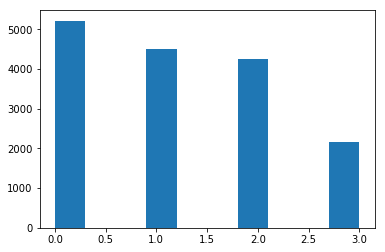

In [43]:
plt.hist(less_5)

(array([  2.39000000e+03,   3.92700000e+03,   5.30200000e+03,
          3.41700000e+03,   1.97700000e+03,   7.11000000e+02,
          2.26000000e+02,   4.30000000e+01,   6.00000000e+00,
          2.00000000e+00]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

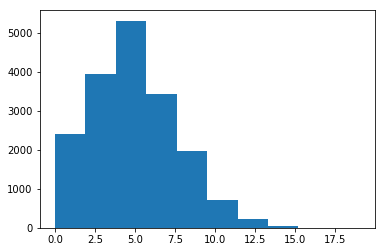

In [44]:
plt.hist(longer_5)